<a href="https://colab.research.google.com/github/Hotckiss/image_analysis/blob/master/Copy_of_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание №4

Задание присылать на обе почты почты aleksartamonov@gmail.com dashkov.alexander.om@gmail.com в виде ссылки на colab

В теме письма указать **HSE2020 HW4 <Фамилия Имя>**

soft deadline: 15.03.2020T23:59:00+0300

hard deadline: 22.03.2020T23:59:00+0300

In [0]:
# https://github.com/dougian/lsh

from copy import copy
from itertools import combinations
import numpy as np
from pandas import DataFrame
from sklearn.metrics.pairwise import pairwise_distances


class LSH:
    def __init__(self, data):
        self.data = data
        self.model = None

    def __generate_random_vectors(self, num_vector, dim):
        return np.random.randn(dim, num_vector)

    def train(self, num_vector, seed=None):
        dim = self.data.shape[1]
        if seed is not None:
            np.random.seed(seed)

        random_vectors = self.__generate_random_vectors(num_vector, dim)
        powers_of_two = 1 << np.arange(num_vector - 1, -1, -1)

        table = {}

        # Partition data points into bins
        bin_index_bits = (self.data.dot(random_vectors) >= 0)

        # Encode bin index bits into integers
        bin_indices = bin_index_bits.dot(powers_of_two)

        # Update `table` so that `table[i]` is the list of document ids with bin index equal to i.
        for data_index, bin_index in enumerate(bin_indices):
            if bin_index not in table:
                # If no list yet exists for this bin, assign the bin an empty list.
                table[bin_index] = []
            # Fetch the list of document ids associated with the bin and add the document id to the end.
            table[bin_index].append(data_index)

        self.model = {'bin_indices': bin_indices, 'table': table,
                      'random_vectors': random_vectors, 'num_vector': num_vector}
        return self

    def __search_nearby_bins(self, query_bin_bits, table, search_radius=2, initial_candidates=set()):
        num_vector = self.model['num_vector']
        powers_of_two = 1 << np.arange(num_vector - 1, -1, -1)

        # Allow the user to provide an initial set of candidates.
        candidate_set = copy(initial_candidates)

        for different_bits in combinations(range(num_vector), search_radius):
            alternate_bits = copy(query_bin_bits)
            for i in different_bits:
                alternate_bits[i] = 1 if alternate_bits[i] == 0 else 0

            # Convert the new bit vector to an integer index
            nearby_bin = alternate_bits.dot(powers_of_two)

            # Fetch the list of documents belonging to the bin indexed by the new bit vector.
            # Then add those documents to candidate_set
            if nearby_bin in table:
                candidate_set.update(table[nearby_bin])

        return candidate_set

    def query(self, query_vec, k, max_search_radius, initial_candidates=set()):

        if not self.model:
            print('Model not yet build. Exiting!')
            exit(-1)

        data = self.data
        table = self.model['table']
        random_vectors = self.model['random_vectors']

        bin_index_bits = (query_vec.dot(random_vectors) >= 0).flatten()

        candidate_set = set()
        # Search nearby bins and collect candidates
        for search_radius in range(max_search_radius + 1):
            candidate_set = candidate_set.union(self.__search_nearby_bins(bin_index_bits, table,
                                                      search_radius, initial_candidates=initial_candidates))
        # Sort candidates by their true distances from the query
        nearest_neighbors = DataFrame({'id': list(candidate_set)})
        candidates = data[np.array(list(candidate_set)), :]
        nearest_neighbors['distance'] = pairwise_distances(candidates, query_vec.reshape(1, -1), metric='cosine').flatten()

        return nearest_neighbors.nsmallest(k, 'distance')

In [0]:
!wget http://www.fftw.org/fftw-3.3.8.tar.gz
!tar -xzvf fftw-3.3.8.tar.gz
%cd fftw-3.3.8
!./configure --enable-single --enable-shared
!make
!make install
%cd ../

# Поиск изображений по содержанию (30 (+20) баллов)

Вам предстоит построить систему, которая позволит выполнить поиск изображений по содержанию в базе Corel-10k, которая приложена к домашнему заданию. База состоит из 100 классов изображений по 100 изображений в каждом классе. Имя каждого изображения в базе состоит из **X.JPEG**, где X - число от 1 до 10000. Изображения из одного класса лежат подряд в промежутке 1-100, 101-200, и тд. В файле **test.dat** лежит список картинок, которые не должны участвовать в построении поисковой базы, но по которым надо будет сделать 1000 поисковых запросов. Ограничение по памяти -- 2Гб.

1. По изображениям не попавшим в **test.dat** посчитайте дескриптор с помощью алгоритма GIST.
   
2. Разбейте дескрипторы всех изображений на 100 кластеров с помощью K-Means.

3. Для каждого кластера постройте функцию хэширования (LSH), с помощью которой закодируйте каждое изображение в тренировочной выборке.

5. Релизуйте функцию `retrieve` продемонстрируйте работу `retrieve` на 5-ти случайных изображениях из **test.dat**. Замерьте время исполнения поискового запроса. Сделайте возможность вызвать `retrieve` без построения индекса, то есть приложите в решение индексированную базу, если только время построения индекса не укладывается в 1 минуту.  

5. Сделайте 1000 запросов изображениями из файла **test.dat**.  Замерьте среднее время исполнения поискового запроса в colab ноутбуке.

    
6. Для каждого запроса нужно оценить MAPk, где k=10 и посчитать среднее значение этой величины по всем запросам.

Так же за это задание можно получить еще до 20-ти дополнительных баллов. 

1. Вы можете сделать быстрый поиск. Если качество вашего поиска окажется выше, чем медиана качества по всем поисковым движкам, то вы принимаете участие в 
борьбе за 10 призовых баллов. Первое место получает 10 баллов, второе 9, третье 8 и т.д. 

2. Вы можете сделать хороший поиск. Если ваш поиск окажется быстрее, чем медиана среднего времени работы других участников, то вы принимаете участие в борьбе за точный поиск. Распределение баллов здесь будет такое же как и в конкурсе на скорость. 

Для достижения лучших результатов вам придется регулировать несколько параметров алгоритма:
- Дескриптор. Можете взять что угодно вместо GIST
- Количество кластеров k-means
- Длину кода LSH
- etc 

Принципиально нельзя использовать готовые поисковые движки. И помните о том, что время поиска очень важный параметр.

In [0]:
!wget https://github.com/tuttieee/lear-gist-python/archive/master.zip
!unzip master.zip

In [0]:
%cd ./lear-gist-python-master
!wget http://lear.inrialpes.fr/src/lear_gist-1.2.tgz
!tar zxvf lear_gist-1.2.tgz
!sudo apt-get install libfftw3-3
!python setup.py build_ext
!python setup.py install

In [138]:
!pip install ml_metrics

  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-cp36-none-any.whl size=7850 sha256=a4dc15cf9cc1bd26c26b5b348134fb983a54ae415558174dabdd511ffd3bb941
  Stored in directory: /root/.cache/pip/wheels/b3/61/2d/776be7b8a4f14c5db48c8e5451451cabc58dc6aa7ee3801163
Successfully built ml-metrics


In [0]:
import gist
import numpy as np
import cv2
import pickle
import random
import matplotlib.pylab as plt
import time
import ml_metrics as metrics
import zipfile
from tqdm.auto import tqdm
from collections import defaultdict
from sklearn.cluster import KMeans

In [0]:
def save_index(index):
  with open('hw4/index.pkl', 'wb') as f:
    pickle.dump(index, f)

In [0]:
def load_index():
  with open('hw4/index.pkl', 'rb') as f:
    return pickle.load(f)

In [0]:
def retrieve(images_, n, index):
  descriptor = lambda t: gist.extract(t, 4, [8, 8, 8, 8])
  images_ = descriptor(images_)
  dct = index.d_hashed[int(index.k_means.predict(images_.reshape(1, -1)))]
  lsh, indices = dct['lsh'], dct['idx']
  return np.array([indices[idx] for idx in lsh.query(images_, n, 3)['id'].keys()])

In [0]:
class ImageWrapper:
    def __init__(self, _path, data):
        self.full_name = _path.split('/')[-1].split('.')[0].split('_')
        self.data = data

    def label(self):
        return int(self.full_name[0])

    def name(self):
        return self.full_name[1] + '.JPEG'

    def image(self):
        res = cv2.imdecode(np.frombuffer(self.data, np.uint8), cv2.IMREAD_COLOR) 
        return cv2.resize(cv2.cvtColor(res, cv2.COLOR_BGR2RGB), (64, 64))

In [0]:
with open('hw4/test.dat', 'r') as f:
    test_names = [l.strip() for l in f]

In [388]:
wrappers = []
with zipfile.ZipFile('hw4/Corel.zip', 'r') as zip_file:
    for filepath in tqdm(zip_file.namelist()):
        if filepath.endswith('.jpg'):
            wrappers.append(ImageWrapper(filepath, zip_file.read(filepath)))

In [0]:
X_train, X_test, Y_train, Y_test = [], [], [], []
for w in wrappers:
    if w.name() in test_names:
        X_test.append(w.image())
        Y_test.append(w.label())
    else:
        X_train.append(w.image())
        Y_train.append(w.label())
X_train, X_test, Y_train, Y_test = np.array(X_train), np.array(X_test), np.array(Y_train), np.array(Y_test)

In [0]:
def build_descriptors(images):
    descriptor = lambda t: gist.extract(t, 4, [8, 8, 8, 8])
    descripted_example = descriptor(images[0])
    result = np.empty((len(images), descripted_example.shape[0]), dtype=descripted_example.dtype)
    for i in tqdm(range(len(images))):
        result[i] = descriptor(images[i])
    return result

In [0]:
class Storage:
    def __init__(self, gist_):
        self.gist = gist_

    def fit(self):
        self.k_means = KMeans(n_clusters=100, random_state=41).fit(self.gist)

    def build(self):
        data = defaultdict(lambda: {'idx': [], 'gist': []})

        for i, l in enumerate(self.k_means.labels_):
            data[l]['idx'].append(i)
            data[l]['gist'].append(self.gist[i])
            
        self.d_hashed = {}
        for l, item_ in data.items():
            data_ = np.array(item_['gist'])
            idx = np.array(item_['idx'])
            lsh = LSH(data_)
            lsh.train(12)
            self.d_hashed[l] = {'idx': idx, 'lsh': lsh}
    
    def show_size(self):
        print(os.path.getsize('hw4/index.pkl') / (2 ** 30))

In [0]:
storage = Storage(build_descriptors(X_train))

In [0]:
storage.fit()

In [0]:
storage.build()

In [0]:
save_index(storage)

In [368]:
storage.show_size()

0.11762209516018629


In [0]:
index = load_index()
tests_ = X_test[random.sample(list(np.arange(len(X_test))), k=5)]

time: 0.0371549129486084


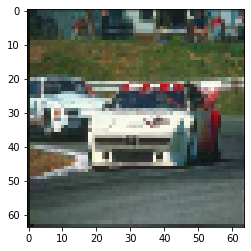

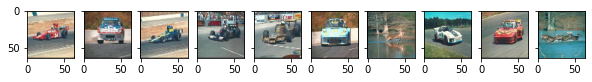

time: 0.0368344783782959


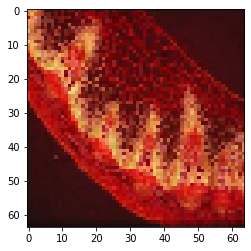

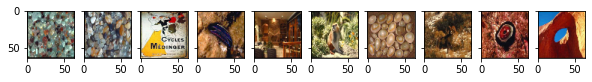

time: 0.04501485824584961


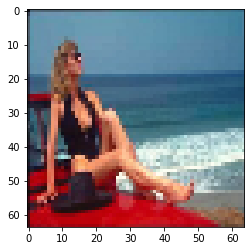

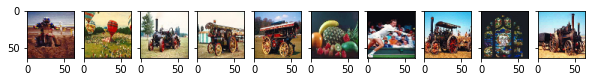

time: 0.04791450500488281


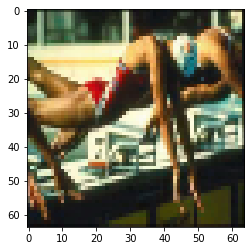

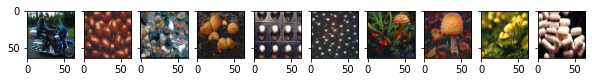

time: 0.0431363582611084


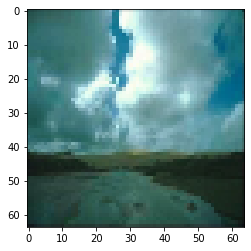

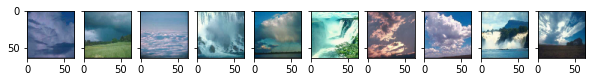

In [402]:
for i, test_ in enumerate(tests_):
    t = time.time()
    images_idx = retrieve(test_, 10, index)
    print("time: " + str(time.time() - t))
    images = X_train[images_idx]
    plt.imshow(test_)
    fig, ax = plt.subplots(1, 10, figsize=(10, 10), sharex=True, sharey=True)
    for i, res in enumerate(images):
        ax[i].imshow(res)
    plt.show()

In [403]:
times_ = []
for test_ in tqdm(X_test):
    t = time.time()
    retrieve(test_, 10, index)
    times_.append(time.time() - t)
print("avg time: " + str(np.mean(times_)))  


avg time: 0.03570363330841064


In [410]:
truth_ = defaultdict(lambda: [])
for i in range(len(X_train)):
    truth_[Y_train[i]].append(i)

print("map@10: " + str(metrics.mapk([truth_[i] for i in Y_test], [retrieve(i, n=10, index=index) for i in X_test], k=10)))

map@10: 0.1849268650793651


# Сегментация изображений (20 баллов)

Решите задачу сегментации изображений для набора http://www.vision.caltech.edu/Image_Datasets/leaves/leaves.tar Результатом сегментации каждого изображения должно быть изображение с разметкой листа выделенного на черном фоне. Оценка работы алгоритма будет производится по аккуратности выделения сегментов, которые соответствуют листьям. Выделение листьев будет оцениваться по F-мере, вычисленной попиксельно относительно ручной разметки сегментов. В качестве результата выполнения задания помимо исходного кода необходимо прислать полученные результаты сегментации для всех изображений коллекции. (положить их в отдельную папку не изменяя имя файлов leaves/*.jpg > result/*.jpg)

In [0]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [149]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp /content/gdrive/My\ Drive/hw4 -r ./

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!unzip -q hw4/leaves.zip

In [3]:
!ls

gdrive	hw4  leaves  __MACOSX  sample_data


In [0]:
names = np.array(list(sorted(list(os.listdir("leaves"))))[1:])

In [0]:
images = [cv2.cvtColor(cv2.imread("leaves/" + i), cv2.COLOR_BGR2RGB) for i in names]

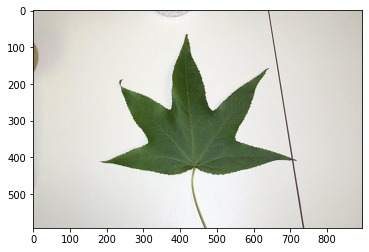

In [13]:
plt.imshow(images[0])

In [0]:
def clear_font(image_):
    split = np.split(image_, 3, axis=2)
    r, g, b = split[0], split[1], split[2]
    rb, gb, bb = np.all(r > [140], axis=-1), np.all(g > [140], axis=-1), np.all(b > [140], axis=-1)
    rs, gs, bs = np.all(r < [30], axis=-1), np.all(g < [30], axis=-1), np.all(b < [30], axis=-1)
    big_ = rb & bb & gb
    small_ = rs & gs & bs
    gSr =  np.squeeze(g < r)
    gSb =  np.squeeze(g < b)
    g_not_biggest = gSr | gSb
    return big_ | small_ | g_not_biggest

In [0]:
from tqdm.auto import tqdm

In [114]:
images_cleared = []
for id in tqdm(range(len(images))):
    img_ = images[id].copy()
    img_[clear_font(img_)] = [0, 0, 0]
    images_cleared.append(img_)


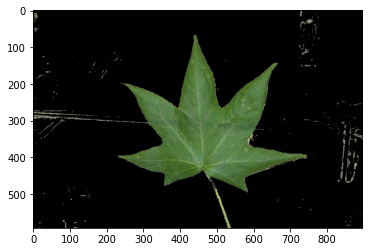

In [136]:
plt.imshow(images_cleared[36])

In [0]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import slic
from skimage.util import img_as_float
from skimage import io

In [0]:
def segmentation(images_):
    result = []

    for image in tqdm(images_):
        slic_ = slic(img_as_float(image), n_segments=7, compactness=10, sigma=1)
        w, h = slic_.shape[0], slic_.shape[1]
        leaf_id = slic_[w // 2][h // 2] # leaf at center

        res_i = image.copy()
        res_i[slic_ != leaf_id] = [0, 0, 0]
        result.append(res_i)

    return result

In [121]:
segmented_leafs = segmentation(images_cleared)

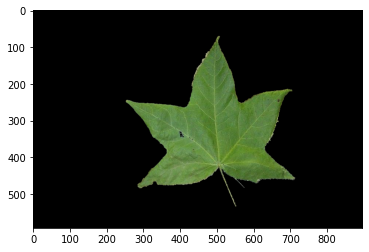

In [193]:
plt.imshow(segmented_leafs[50])

In [132]:
!mkdir result
for i, image in tqdm(enumerate(segmented_leafs)):
        cv2.imwrite("result/" + names[i], image)

In [0]:
!zip -r result.zip result